# Reinforced Concrete Frame Earthquake Analysis

This is an interactive analysis example by where the user can gain an insight into how the finite element analysis is performed using the OpenSees framework. The interactive sliders also allow for the user to vary key parameters and see how the plotted response of the frame is influenced by these changes.

### Geometry

The reinforced concrete (RC) frame is a simple two dimensional, single storey/ one bay frame with fixed supports. The width and height of the frame are 360 and 144 inches, respectively.

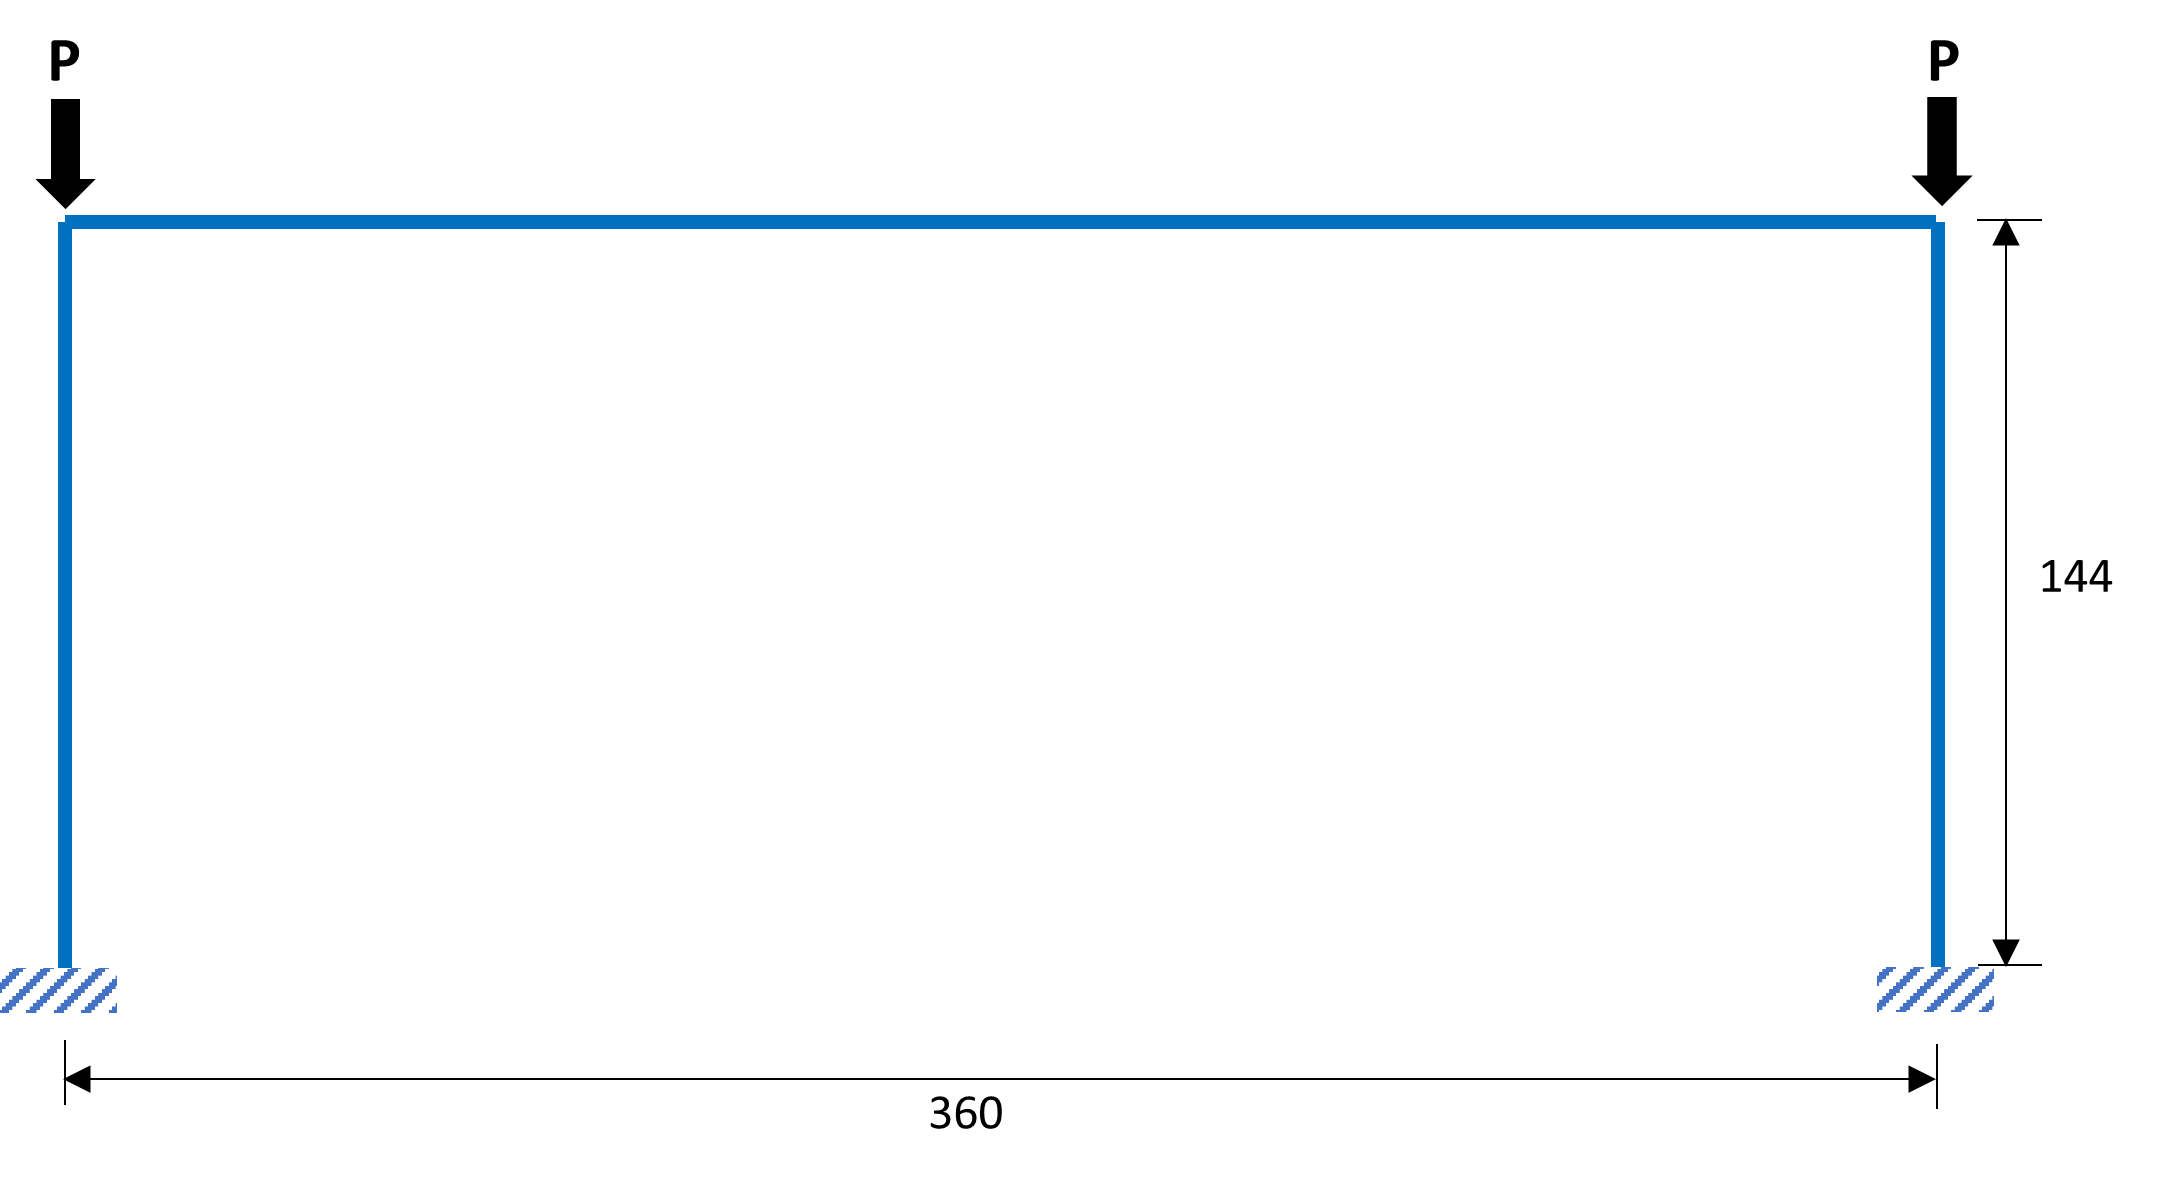

The RC frame is composed of four nodes. Each node has three degrees of freedom.

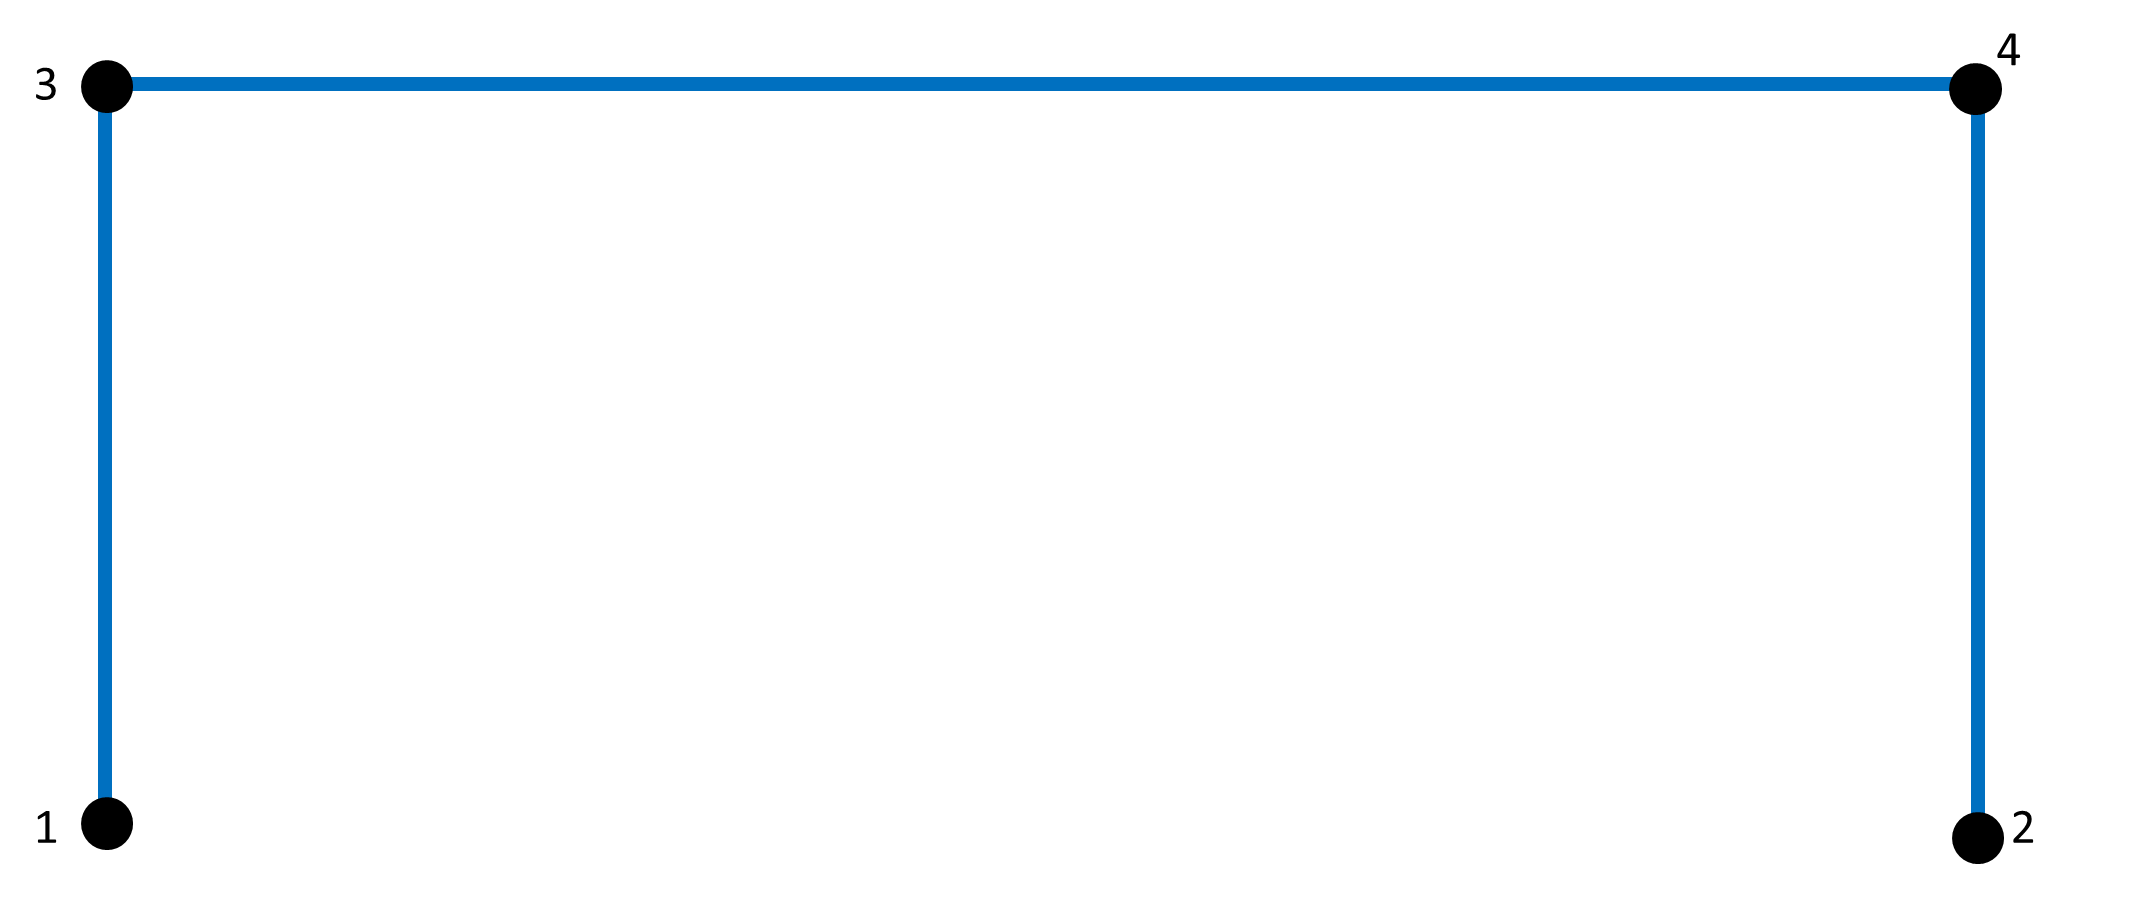

### Materials defined:



The materials are split into three categories.
- core concrete
- cover concrete
- reinforcing steel

The core concrete is confined by the transverse reinforcement and therefore has different properties to the unconfined cover concrete. The stress-strain behaviour of these two concrete components is shown below:

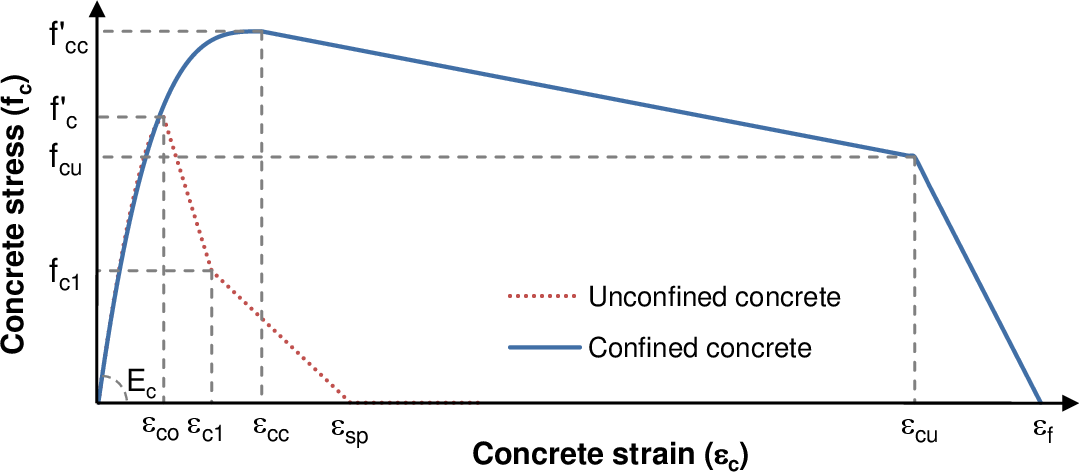

Accessed 16/09/2022 from https://www.semanticscholar.org/paper/Stress-Strain-Model-of-Unconfined-and-Confined-and-Reddiar-Karthik/a81fce7a4597c24c764b68f66f8db545010a0e52

Uniaxial materials are defined numerically, using a stress-strain relationship, and are combined into a fiber section. This is where moment-curvature, axial force-deformation, and the interaction between these characteristics, are calculated computationally. Fiber sections are distribituted non-plasticity elements, yielding can occur at any point along the element.
      

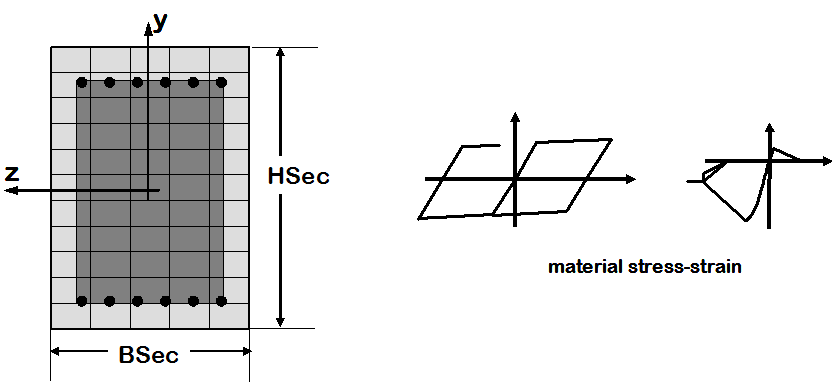

Accessed 16/09/2022 from https://opensees.berkeley.edu/wiki/index.php/OpenSees_Example_9._Build_%26_Analyze_a_Section_Example#Fiber_Section:_Reinforced_Concrete_Section_--_Rectangular_Section

In [1]:
from openseespy.opensees import *
import opsvis as opsv
import ipywidgets as widgets
import ReadRecord
import numpy as np
import matplotlib.pyplot as plt

def interactive_RC_frame_EQ(fy = 60.0, As = 0.60 , cover = 1.5, colDepth = 24):
    
    # Units: kips, in, sec  
    
    wipe()

    # Create ModelBuilder (with two-dimensions and 3 DOF/node)
    model('basic', '-ndm', 2, '-ndf', 3)

    # Create nodes
    # ------------

    # Set parameters for overall model geometry
    width = 360.0 
    height = 144.0

    # Create nodes
    #    tag, X, Y
    node(1, 0.0, 0.0)
    node(2, width, 0.0)
    node(3, 0.0, height)
    node(4, width, height)

    # Fix supports at base of columns
    #   tag, DX, DY, RZ
    fix(1, 1, 1, 1)
    fix(2, 1, 1, 1)

    # Define materials for nonlinear columns
    # ------------------------------------------
    # CONCRETE                   tag  f'c    ec0    f'cu   ecu
    # Core concrete (confined)
    uniaxialMaterial('Concrete01', 1, -6.0, -0.004, -5.0, -0.014)

    # Cover concrete (unconfined)
    uniaxialMaterial('Concrete01', 2, -5.0, -0.002, 0.0, -0.006)

    # STEEL
    # Reinforcing steel
    E = 30000.0;  # Young's modulus ksi
    #                         tag  fy E0    b
    uniaxialMaterial('Steel01', 3, fy, E, 0.01)

    # Define cross-section for nonlinear columns
    # ------------------------------------------


    #cover = cover
    As = As #0.60  # area of no. 7 bars

    # some variables derived from the parameters
    colWidth = 15
    y1 = colDepth / 2.0
    z1 = colWidth / 2.0
    
    
    section('Fiber', 1)

    # Create the concrete core fibers
    patch('rect', 1, 10, 1, cover - y1, cover - z1, y1 - cover, z1 - cover)

    # Create the concrete cover fibers (top, bottom, left, right)
    patch('rect', 2, 10, 1, -y1, z1 - cover, y1, z1)
    patch('rect', 2, 10, 1, -y1, -z1, y1, cover - z1)
    patch('rect', 2, 2, 1, -y1, cover - z1, cover - y1, z1 - cover)
    patch('rect', 2, 2, 1, y1 - cover, cover - z1, y1, z1 - cover)

    # Create the reinforcing fibers (left, middle, right)
    layer('straight', 3, 3, As, y1 - cover, z1 - cover, y1 - cover, cover - z1)
    layer('straight', 3, 2, As, 0.0, z1 - cover, 0.0, cover - z1)
    layer('straight', 3, 3, As, cover - y1, z1 - cover, cover - y1, cover - z1)
    
    ######re create fiber section for the purpose of plotting
    fib_sec_1 = [ ['section', 'Fiber', 1],

             ['patch', 'rect', 1, 10, 1, cover - y1, cover - z1, y1 - cover, z1 - cover], # Create the concrete core fibers

             ['patch', 'rect', 2, 10, 1, -y1, z1 - cover, y1, z1],

             ['patch', 'rect', 2, 10, 1, -y1, -z1, y1, cover - z1],
                 
             ['patch', 'rect', 2, 2, 1, -y1, cover - z1, cover - y1, z1 - cover],

             ['patch', 'rect', 2, 2, 1, y1 - cover, cover - z1, y1, z1 - cover],
                 
             ['layer', 'straight', 3, 3, As, y1 - cover, z1 - cover, y1 - cover, cover - z1],
                 
             ['layer', 'straight', 3, 2, As, 0.0, z1 - cover, 0.0, cover - z1],

             ['layer', 'straight', 3, 3, As, cover - y1, z1 - cover, cover - y1, cover - z1],

             ]
    
  
    # Define column elements
    # ----------------------

    # Geometry of column elements
    #                tag

    geomTransf('PDelta', 1)   

    # Number of integration points along length of element
    num_int_points = 5

    # Lobatto integratin ('Lobatto', tag, secTag, N)
    beamIntegration('Lobatto', 1, 1, num_int_points) 

    # Create the coulumns using Beam-column elements
    #               e            tag ndI ndJ transfTag integrationTag
    eleType = 'forceBeamColumn'
    element(eleType, 1, 1, 3, 1, 1)
    element(eleType, 2, 2, 4, 1, 1)

    # Define beam elment
    # -----------------------------

    # Geometry of column elements
    #                tag
    geomTransf('Linear', 2)

    # Create the beam element
    #                          tag, ndI, ndJ, A,     E,    Iz, transfTag
    element('elasticBeamColumn', 3, 3, 4, 360.0, 4030.0, 8640.0, 2)

    # Define gravity loads
    # --------------------

    #  a parameter for the axial load
    P = 180.0;  # 10% of axial capacity of columns

    # Create a Plain load pattern with a Linear TimeSeries
    timeSeries('Linear', 1)
    pattern('Plain', 1, 1)

    # Create nodal loads at nodes 3 & 4
    #    nd  FX,  FY, MZ
    load(3, 0.0, -P, 0.0)
    load(4, 0.0, -P, 0.0)
    

    # Define nodal mass in terms of axial load on columns
    g = 386.4
    m = P/g

    mass(3, m, 0.01, 0.01)
    mass(4, m, 0.01, 0.01)

    # ------------------------------
    # End of model generation
    # ------------------------------
      

        
    # Perform an eigenvalue analysis
    #numEigen = 1
    #eigenValues = eigen('fullGenLapack', numEigen) 
    
    
    # ------------------------------
    # Start of analysis generation
    # ------------------------------

    # Create the system of equation, a sparse solver with partial pivoting
    system('BandGeneral')

    # Create the constraint handler, the transformation method
    constraints('Transformation')

    # Create the DOF numberer, the reverse Cuthill-McKee algorithm
    numberer('RCM')

    # Create the convergence test, the norm of the residual with a tolerance of
    # 1e-6 and a max number of iterations of 10
    test('NormDispIncr', 1.0e-6, 10, 3)

    # Create the solution algorithm, a Newton-Raphson algorithm
    algorithm('Newton')

    # Create the integration scheme, the LoadControl scheme using steps of 0.1
    integrator('LoadControl', 0.1)

    # Create the analysis object
    analysis('Static')

    # ------------------------------
    # End of analysis generation
    # ------------------------------
    # ------------------------------
    # Finally perform the analysis
    # ------------------------------

    # perform the gravity load analysis, requires 10 steps to reach the load level
    analyze(10)

    # Print out the state of nodes 3 and 4
    # print node 3 4

    # Print out the state of element 1
    # print ele 1

    u3 = nodeDisp(3, 2)
    u4 = nodeDisp(4, 2)
    

    results = open('results.out', 'a+')

    results.close()
    
    # Units: kips, in, sec  
    #
    # Written: Minjie

    # ----------------------------------------------------
    # Start of Model Generation & Initial Gravity Analysis
    # ----------------------------------------------------


    # Set the gravity loads to be constant & reset the time in the domain
    loadConst('-time', 0.0)

    # ----------------------------------------------------
    # End of Model Generation & Initial Gravity Analysis
    # ----------------------------------------------------

    # Define nodal mass in terms of axial load on columns
    g = 386.4
    m = P/g

    mass(3, m, 0.01, 0.01)
    mass(4, m, 0.01, 0.01)

    # Set some parameters
    record = 'elCentro'

    # Permform the conversion from SMD record to OpenSees record
    dt, nPts = ReadRecord.ReadRecord(record+'.at2', record+'.dat')

    # Set time series to be passed to uniform excitation
    timeSeries('Path', 2, '-filePath', record+'.dat', '-dt', dt, '-factor', g)

    # Create UniformExcitation load pattern
    #                         tag dir 
    pattern('UniformExcitation',  2,   1,  '-accel', 2)

    # set the rayleigh damping factors for nodes & elements
    rayleigh(0.0, 0.0, 0.0, 0.000625)

    # Delete the old analysis and all it's component objects
    wipeAnalysis()

    # Create the system of equation, a banded general storage scheme
    system('BandGeneral')

    # Create the constraint handler, a plain handler as homogeneous boundary
    constraints('Plain')

    # Create the convergence test, the norm of the residual with a tolerance of 
    # 1e-3 and a max number of iterations of 10
    test('NormDispIncr', 1.0e-3,  10 )

    # Create the solution algorithm, a Newton-Raphson algorithm
    algorithm('Newton')

    # Create the DOF numberer, the reverse Cuthill-McKee algorithm
    numberer('RCM')

    # Create the integration scheme, the Newmark with alpha =0.5 and beta =.25
    integrator('Newmark',  0.5,  0.25 )

    # Create the analysis object
    analysis('Transient')

    # Perform an eigenvalue analysis
    numEigen = 2
    eigenValues = eigen(numEigen)
    
    # set some variables
    tFinal = nPts*dt
    tCurrent = getTime()
    ok = 0

    time = [tCurrent]
    u3 = [0.0]
    moment_1 = [0.0] #moment at node 1
    moment_3 = [0.0] #moment at node 3
    moment_4 = [0.0] #moment at node 4
    moment_2 = [0.0] #moment at node 2   
    
    
    # Perform the transient analysis
    while ok == 0 and tCurrent < tFinal:

        ok = analyze(1, .01)

        # if the analysis fails try initial tangent iteration
        if ok != 0:
            print("regular newton failed .. lets try an initail stiffness for this step")
            test('NormDispIncr', 1.0e-3,  10, 0)
            algorithm('ModifiedNewton', '-initial')
            ok =analyze( 1, .01)
            if ok == 0:
                print("that worked .. back to regular newton")
            test('NormDispIncr', 1.0e-3,  10 )
            algorithm('Newton')

        tCurrent = getTime()

        time.append(tCurrent)
        u3.append(nodeDisp(3,1))
        
        moment_1.append(eleResponse(1,'forces')[2]) # moment node 1 from element 1
        moment_3.append(eleResponse(1,'forces')[5]) # moment node 3 from element 1
        moment_4.append(eleResponse(2,'forces')[5]) # moment node 4 from element 2
        moment_2.append(eleResponse(2,'forces')[2]) # moment node 2 from element 2
        
    results.close()        
        
    ######plotting BMD#########
    
    w = 35000*1.5
    h = 14000*1.5
    
    # create data
    x = np.linspace(0,w,10)
    y = np.linspace(0,h,10)

    #create frame

    ele_2 = np.ones(10) * h
    ele_3 = np.ones(10) * w
    ele_1 = np.zeros(10)
    
    m1 = max(max(moment_1),-min(moment_1))        
    m3 = max(max(moment_3),-min(moment_3))    
    m4 = max(max(moment_4),-min(moment_4))        
    m2 = max(max(moment_2),-min(moment_2))    
    
    mom_1 = np.linspace(-m1,m3,10) # moment distribution along element 1 (LHS column)
    mom_3 = np.linspace(-m2+w,m4 + w,10) # moment distrubution along element 2 (RHS column)
    mom_2 = np.linspace(-m4+h,m3+h, 10) #moment distrubution along element 3 (beam)
    
    #plot the section
    matcolor = ['r', 'lightgrey', 'gold', 'w', 'w', 'w']
    opsv.plot_fiber_section(fib_sec_1, matcolor=matcolor)
    plt.axis('equal')
   
    
    #plot grid
    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (8,6))
    axs = axs.flatten()
    #fig.tight_layout()

    

    # plot lines for bending moment diagram assuming linear distrubution of moment    
 
    axs[1].plot(ele_1, y, label = "LHS", color = 'k')
    axs[1].plot(mom_1, y, color = 'k', linewidth = 0.5)
    axs[1].fill_betweenx(y, mom_1, ele_1, where= mom_1 >= ele_1, facecolor='red', interpolate=True) 
    axs[1].fill_betweenx(y, mom_1, ele_1, where= mom_1 <= ele_1, facecolor='green', interpolate=True ) 
    axs[1].set_ylim(0,0.6*w)
    axs[1].set_xlim(-0.5*w,1.5*w)
    
    
    axs[1].plot(ele_3, y, label = "RHS",color = 'k')
    axs[1].plot(mom_3, y,color = 'k', linewidth = 0.5)
    axs[1].fill_betweenx(y, mom_3, ele_3,  where= mom_3 >= ele_3, facecolor='red', interpolate=True )
    axs[1].fill_betweenx(y, mom_3, ele_3, where= mom_3 <= ele_3, facecolor='green', interpolate=True ) 
    
    axs[1].plot(x, ele_2, label = "Beam",color = 'k')
    axs[1].plot(x, mom_2,color = 'k', linewidth = 0.5)
    axs[1].fill_between(x, mom_2, ele_2, where= mom_2 >= ele_2, facecolor='green', interpolate=True)
    axs[1].fill_between(x, mom_2, ele_2, where= mom_2 <= ele_2, facecolor='red', interpolate=True)
    
    axs[1].text(-(5000 + m1),0,"{:.0f}".format(m1) , fontsize = 8)
    axs[1].text(5000,h+200,"-"+"{:.0f}".format(m3) , fontsize = 8)
    
    axs[1].text(-5000,h-m2,"-"+"{:.0f}".format(m3) , fontsize = 8)
    axs[1].text(w,h+m2, "{:.0f}".format(m4) , fontsize = 8)
    
    axs[1].text(w - m3 - 5000,0,"{:.0f}".format(m2) , fontsize = 8)
    axs[1].text(m3+w, h,"-"+"{:.0f}".format(m4) , fontsize = 8)


    plt.xticks(color='w')
    plt.yticks(color='w')
    plt.xlabel('Length')
    plt.ylabel('Bending Moment (in.kips)')
   
        
    max_disp = max(max(u3),-min(u3))    
    print("The maximum node displacement is " + "{:.2f}".format(max_disp) + " inches")
    

    #Plotting Displacement
    axs[0].plot(time,u3, color='m', linewidth = 0.5)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Horizontal Displacement (in)')
    axs[0].grid(linestyle = '-.')
    axs[0].set_ylim(-3.5,3.5)  
    axs[0].text(10,2.2 ,"Maximum displacement is "+ "{:.2f}".format(max_disp) + " inches", fontsize = 14)
    
    plt.tight_layout()
    plt.show()
 
    pass


In [2]:
widgets.interact(interactive_RC_frame_EQ,fy = widgets.IntSlider(min=36, max=66,step = 2, continuous_update=False), As = widgets.FloatSlider(min=0.4, max=1.0,step = 0.2, continuous_update=False), cover =[1.0,1.5,2.0], colDepth = [15,25,40])

interactive(children=(IntSlider(value=36, continuous_update=False, description='fy', max=66, min=36, step=2), …

<function __main__.interactive_RC_frame_EQ(fy=60.0, As=0.6, cover=1.5, colDepth=24)>